In [1]:
from pylib import ipynb_docgen
def fg(figw):
    if (fignum := figw.fignum) is not None:
        figw.fig.savefig(f'figures/high_curvature-fig{figw.fignum:02d}.png', bbox_inches='tight')    
ipynb_docgen.figure_callback=fg 

%run pylib/ml_fit show kde title "High-curvature Selection for GI proposal"
show("""[Confluence](https://confluence.slac.stanford.edu/pages/editpage.action?pageId=429560332)""")
data = dfc

# High-curvature Selection for GI proposal

<h5 style="text-align:right; margin-right:15px"> 2024-02-14 10:57</h5>

Not applying ML, so no fit to targets to generate prediction model. Instead we compute KDE probability density distributions
for the ML targets, which we then apply to the unid and bcu associations.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fa4f35b10c0>

### Data selection cut: "0.15<Ep<4 & d>0.2 & variability<25"

subset,blazar,psr,msp,unid
total,2283,140,176,2349
selected,162,128,169,1389
%,7,91,96,59


## Create KDE functions  in lieu of ML training
* Features: ['d', 'log_epeak', 'diffuse'] 
* Targets: dict_keys(['psr', 'msp', 'blazar'])

[Confluence](https://confluence.slac.stanford.edu/pages/editpage.action?pageId=429560332)

## Spectral shapes of the associated and unid sources. 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fa4c1cfcaf0>
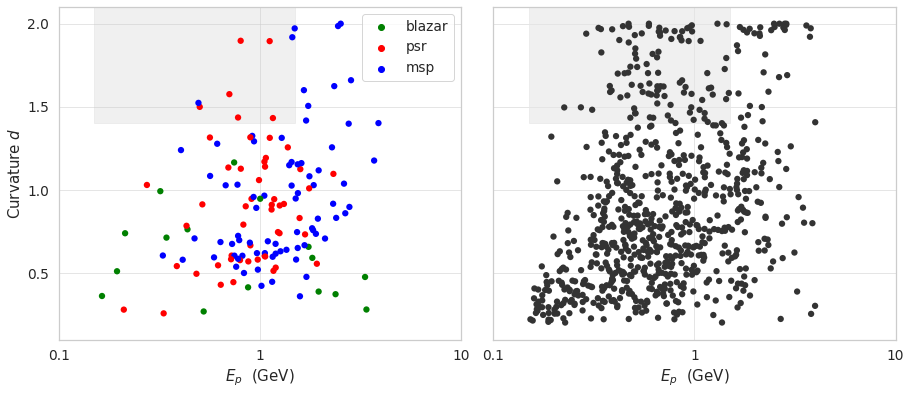

In [17]:
def plot_spectral(self, df, emax=1.5):
    """Spectral shape scatter plots: curvature $d$ vs $E_p$ for the associated sources on the left, and 
    the unid's on the right.
    """

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6), sharex=True, sharey=True,
                                gridspec_kw=dict(wspace=0.08))
    kw = dict(x='log_epeak', y='d',  hue='subset', s=40, edgecolor='none', zorder=10 )
    sns.scatterplot(df, ax=ax1, hue_order=self.target_names,  **kw,
                    palette=self.palette, legend='brief');
    ax1.set(**epeak_kw(), yticks=np.arange(0.5,2.1,0.5), ylabel='Curvature ${d}$',
        xlim=(-1,1),ylim=(0.1,2.1));
    vskw = dict(color='0.9', alpha=0.6, zorder=0)
    ax1.axvspan(*np.log10([0.15,emax]), 0.65,1, **vskw)  
    ax1.legend(loc='upper right')
    vskw = dict(color='0.9', alpha=0.6,)
    sns.scatterplot(df, ax=ax2, **kw, 
                    hue_order=['unid'], palette=['0.2'], legend=False,  )
    kw.pop('s');kw.pop('edgecolor')
    # ax2.legend(loc='upper right')
    ax2.axvspan(*np.log10([0.15,emax]), 0.65,1, **vskw )

    # sns.kdeplot(df, ax=ax2, **kw, hue_order=self.target_names, palette=self.palette, alpha=0.4,legend=False );
    ax2.set(**epeak_kw(),)# yticks=np.arange(0.5,2.1,0.5));
    return fig
show(f"""## Spectral shapes of the associated and unid sources. """)
show_fig( plot_spectral, self, data.query('0.2<diffuse<1.2'), 
         fignum=1)

In [20]:
show(f"""* Corner selection: '{(cut:='d>1.4 & Ep<1.5 & 0.2<diffuse<1.2 & subset=="unid"')}' for SED display""")
unid_selected = data.query(cut).loc[:,'significance Ep Fp d glat glon diffuse r95 msp_kde psr_kde'.split()]\
    .sort_index() #sort_values('significance', ascending=False); 
show (f'Nummber selected: {len(unid_selected)}')
# unid = data[data.subset=="unid"].copy()
data['in_corner'] = data.apply(lambda s: (s.d>1.4) & (s.Ep<1.5) &(s.diffuse>0.2) &(s.diffuse<1.2) ,
                               axis=1)
show(pd.Series(data[data.in_corner].groupby('subset').size(), name='in corner'))
data['unid'] = data.subset=='unid'


* Corner selection: 'd>1.4 & Ep<1.5 & 0.2<diffuse<1.2 & subset=="unid"' for SED display

Nummber selected: 101

subset,bcu,msp,psr,unid
in corner,15,3,6,101


In [4]:
# data['in_corner'] = data.apply(lambda s: (s.d>1.4) & (s.Ep<1.5) 
#                                &(s.diffuse>0.2) &(s.diffuse<1.2) 
#                                ,
#                                axis=1)
# show(pd.Series(data[data.in_corner].groupby('subset').size(), name='in corner'))

In [5]:
def diffuse_check(data, norms, bins = np.arange(-1,2.6, 0.1)):
    """ Histogram of the diffuse parameter D defined in the text for unid's, showing
    the high-curvature, low-energy subset. Also shown overlayed plots of the KDE approximations
    to the three known categories, with optimized normalizations to measure content.
    """
    from pylib.kde import Gaussian_kde
    kdes = [
        Gaussian_kde(  data.query('subset=="blazar"'), cols=['diffuse'],),
        Gaussian_kde(  data.query('subset=="psr"'),    cols=['diffuse'],), 
        Gaussian_kde(  data.query('subset=="msp"'),    cols=['diffuse'],), 
    ]
    unid = data[data.subset=="unid"]
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(unid, ax=ax, x='diffuse', hue='in_corner', alpha=0.6, palette='grey red'.split(),
             element='step',  edgecolor='w', bins=bins,                 
                 multiple='stack',stat='density');
    ax.set(xlim=(-1,2.5), xticks=np.arange(-1, 2.1, 1),xlabel='$D$')
    
    axt = ax.twinx()
    colors = palette =['cyan', 'magenta', 'yellow']
    names = 'blazar psr msp'.split()
    x=np.linspace(-1,2.5, 52)
    yy = np.array(np.array([norm*kde.evaluate(x) for (kde,norm) in zip(kdes,norms)]))                  
    for y, name in zip(yy, names):
        axt.plot(x,y, label=name, ls='--', lw=2)
    axt.plot(x, np.sum(yy,axis=0), ls='-', lw=2, label='total')
    axt.legend(fontsize=12)

    
    axt.set(ylim=ax.get_ylim())
    axt.legend(title='KDE overlay',loc='center right')
    axt.get_yaxis().set_visible(False)
    return fig

# self = KDEfitter(data, names='blazar psr msp'.split(), bins= np.arange(-1,2.6, 0.1 ))
# def make_df(self, norms):
#     n, bins, x = self.hist, self.bins, self.x
#     factor = n.sum()*(bins[1]-bins[0]) # assume uniform
#     yy = np.array(  [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)] )
#     u  = np.sum(yy, axis=0)*factor
#     df = pd.DataFrame(np.array([n, u]).T, index=pd.Series(x,name='x'), columns=['n','u'])
#     return df
# norms = [0.03, 0.37, 0.4]
# df =  make_df(self, norms )
# show(df.head())

# def loglike(self, norms, range=(None,None)):
#     df = make_df(self,norms)
#     return np.sum(df[slice(*range)].apply( 
#         lambda s: s.n/s.u -1 ,
#         # lambda s: s.n * np.log(s.u)-s.u ,
#         axis =1))

# loglike(self, norms, (0,1))

# from scipy import optimize
# def flike(x, k,  norm=[0.03, 0.32, 0.36]):
#     # k: blazar, psr, msp
#     ranges = [(None,0), (1., None), (None,0), ]
#     norm[k]=x
#     return loglike(self, norm, ranges[k])

# xx= np.arange(0., 0.1, 0.01)
# yy = [flike(x, 0) for x in xx] 
# plt.plot(xx,yy);

# [optimize.brentq( lambda x: flike(x,i,norm=[0.0, 0.26, 0.36]), 0.2, 0.4) for i in (1,2)]


In [21]:
data.groupby('subset').size()


subset
bcu        323
blazar     162
msp        169
psr        128
unid      1389
dtype: int64

### Check diffuse
We associate a Galactic diffuse gamma-ray flux parameter $D$ with each source, 
the log of the energy flux in $\mathrm{ eV\  cm^{-2}\ s^{-1}}$ units at the position of the
source, using the same distribution used for 4FGL. It is a measure of how Galactic a source is,
partlly separating MSPs from young pulsars.
Within the shaded subset, imposing $0.2<D<1.2$,  removes all blazars, and half of the pulsars,
in left panel, but only a third of the UnIDs in the right panel.  

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fa4c12dcbb0>
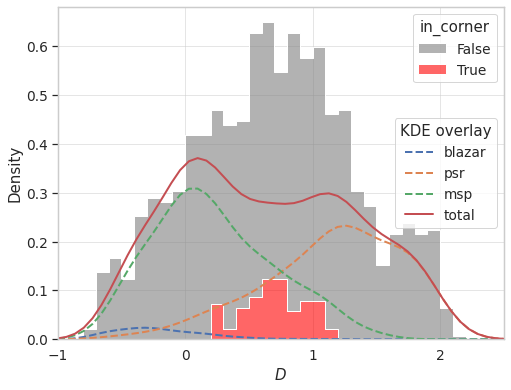

In [22]:
show(r"""### Check diffuse
We associate a Galactic diffuse gamma-ray flux parameter $D$ with each source, 
the log of the energy flux in $\mathrm{ eV\  cm^{-2}\ s^{-1}}$ units at the position of the
source, using the same distribution used for 4FGL. It is a measure of how Galactic a source is,
partlly separating MSPs from young pulsars.
Within the shaded subset, imposing $0.2<D<1.2$,  removes all blazars, and half of the pulsars,
in left panel, but only a third of the UnIDs in the right panel.  
""")
show_fig(diffuse_check, data, norms = [0.02, 0.32, 0.36], fignum=None)

In [23]:
def add_uw_r95(final):
    from wtlike.interface import get_fermi_info
    if dark_mode: plt.style.use('dark_background')
    dfi = get_fermi_info(final.index)    
    final['uw_r95'] = dfi.uw_r95
add_uw_r95(unid_selected)

In [24]:
unid_selected.head()

,significance,Ep,Fp,d,glat,glon,diffuse,r95,msp_kde,psr_kde,uw_r95
4FGL-DR4,,,,,,,,,,,
4FGL J0116.8+6914,7.234,0.506,1.824,1.931,6.481,125.190,0.615,0.148,0.003,0.010,0.115
4FGL J0140.4+5114,4.940,1.211,0.079,1.615,-10.881,130.709,0.320,0.152,0.152,0.124,0.120
4FGL J0142.5+6650,5.419,0.591,1.377,1.580,4.460,127.935,0.901,0.209,0.096,0.067,0.114
4FGL J0305.4+5945,5.180,0.473,2.500,1.981,1.153,139.081,0.978,0.141,0.004,4.08e-04,0.138
4FGL J0340.4+5302,32.113,0.226,661.578,1.497,-1.822,146.792,0.928,0.064,3.04e-04,6.11e-05,0.044


In [25]:
# q = unid_selected.loc[:,'significance Ep Fp d glat glon diffuse r95 uw_r95 msp_kde psr_kde'.split()]
dec = list(map(lambda name: float(name[12:15]), unid_selected.index))
unid_selected['dec'] = dec

show(f""" ## Select final set using "{(finalcut:='r95<0.2 & dec>-35')}" """)
cols='significance Ep Fp d glat glon diffuse r95 uw_r95 msp_kde psr_kde'.split()
final = unid_selected.query(finalcut)[cols]

show(f"""* Writing {len(final)} high-curvature sources to `{(filename:='files/for_GI.csv' )}` """)
final.to_csv(filename, float_format='%.3f')

## Select final set using "r95<0.2 & dec>-35" 

* Writing 49 high-curvature sources to `files/for_GI.csv` 

### Check uw1410 r95, po

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fa4c11ca4d0>
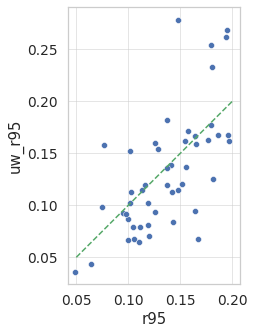

Above 0.13 for DR4: 23, uw1410: 27

In [26]:
show(f"""### Check uw1410 r95, po""")
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(final, x='r95', y='uw_r95');
ax.plot([0.05,0.2], [0.05, 0.2], '--g');
ax.set(aspect=1,);
show(fig)
show(f"""Above 0.13 for DR4: {np.sum(final.r95<0.13)}, uw1410: {np.sum(final.uw_r95<0.13)}""")

## Figure 2 for GI proposal

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fa4c1d27640>
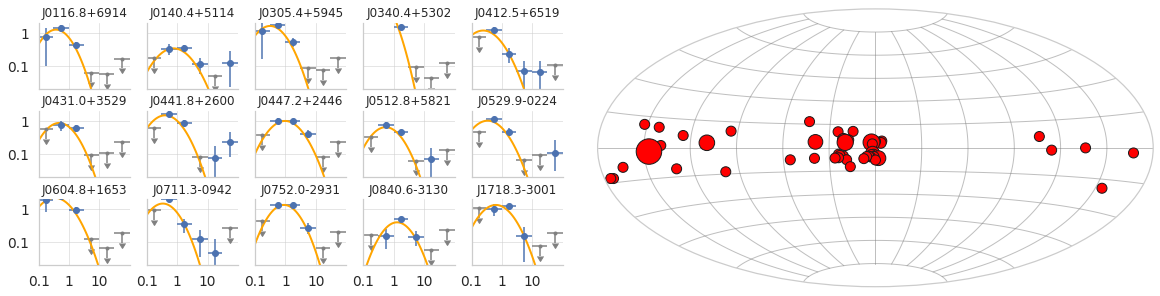

In [27]:
show(f""" ## Figure 2 for GI proposal
""")
if 'dr4' not in globals():
    dr4 = Fermi4FGL('dr4')
def plot_fermi_seds(data, axx=None):
    """SED plots. Horizontal scale is GeV, vertical eV cm-2 s-1.
    """

    N = len(data)
    if axx is None:
        fig, axx = plt.subplots(ncols=(nc:=5), nrows=(N+nc-1)//nc, 
                            figsize=(12,6),sharex=True, sharey=True,
                           gridspec_kw=dict(hspace=0.2,wspace=0.1))
        axx = axx.flatten()
    else:
        fig = None# axx.flatten()[0].figure        
    for ax, name in zip(axx, data.index):
        dr4.band_plot(name, ax=ax)
        ax.set(xlabel='', ylabel='', ylim=(0.02,2),
               yticks=[0.1,1],   yticklabels='0.1 1'.split(),
               xticks=np.logspace(-1,1,3),  xticklabels='0.1 1 10'.split())
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_title(name[5:], fontsize=12)
    for ax in axx[N:] : ax.set_visible(False)
    return fig


from pylib.skymaps import AITfigure
fig = plt.figure(layout="constrained", figsize=(16,4.))
subfigs = fig.subfigures(1, 2, wspace=0.05, hspace=0.5,width_ratios=[2, 2])
axs0 = subfigs[0].subplots(3,5, sharex=True, sharey=True,)
plot_fermi_seds( final.iloc[:15], axx=axs0.flatten());

subfigs[1].add_subplot(111, projection='aitoff')
# axs1 = subfigs[1].subplots(1, 1,)
(AITfigure(fig=subfigs[1])
 .scatter(final, c='red', edgecolor='k', s=100*np.log(final.Fp).clip(1))
 .apply(lambda ax: ax.tick_params(labelbottom=False, labelleft=False) )
)
show(fig, fignum=2, caption="""Final selection: SED plots for represenative subset on the left, 
Galactic positions on the right. """)

In [14]:
# class KDEfitter:
#     """### class KDEfitter
#     """
#     def __init__(self, data, *, names, bins, hue='subset', colname='diffuse'):
        
#         from pylib.kde import Gaussian_kde
#         self.names = names
#         self.colname = colname
#         # make list of 1D KDEE
#         self.kdes = [
#             Gaussian_kde(data.query(f'{hue}=="{name}"'), cols=[colname] )
#                                    for name in names
#                                     ]
#         self.data = data
#         self.hist, self.bins = np.histogram(self.data[self.data.unid][self.colname], bins=bins,)
#         self.x = ( bins[1:]+bins[:-1] )/2
        
#     def __repr__(self):
#         return f'KDEfittter using kdes\n {self.kdes}'

#     def eval(self, norms):
#         """ Evaluate expected counts
#         """
#         h,bins, x = self.hist, self.bins, self.x
#         N = h.sum()
#         factor = N*(bins[1]-bins[0]) # assume uniform
#         yy = np.array(np.array(
#                 [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
#                 )) 
#         u  = np.sum(yy, axis=0)*factor

#         return pd.DataFrame.from_dict(dict(x=x,u=u, h=h))
        
#     def plot(self, ax, norms):
#         # make a twin for separate legend
#         axt = ax.twinx()        
#         x = np.linspace(*ax.get_xlim(), 52)
#         yy = np.array(np.array(
#             [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
#             ))                  
#         for y, name in zip(yy, self.names):
#             axt.plot(x,y, label=name, ls='--', lw=2)
#         axt.plot(x, np.sum(yy,axis=0), ls='-', lw=2, label='total')
#         # same scale--dendsity
#         axt.set(ylim=ax.get_ylim())

#         axt.legend(title='KDE overlay',loc='center right',fontsize=12)
#         axt.get_yaxis().set_visible(False)
# show(KDEfitter.__doc__)

In [15]:
    
# def evaluate(self, norms):
#     """ Evaluate expected counts
#     """
#     n, bins, x = self.hist, self.bins, self.x
#     N = n.sum()
#     factor = N*(bins[1]-bins[0]) # assume uniform
#     yy = np.array(
#             [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
#             )
#     u  = np.sum(yy, axis=0)*factor

#     df = DataFrame.from_dict(dict(x=x, u=u, n=n), orient='index')
#     mask =  x >1.4
#     mask  = x<0
   
#     return np.sum( (n * np.log(u)-u ) * mask)

# plt.plot((x:=np.arange(0.2,0.5, 0.025)), 
#           [evaluate(self, [0.03, 0.37, x]) for x in x], 'o--');
# # [(x, evaluate(self, [0.05, x, 0.5])) for x in np.arange(0.2,0.5, 0.02)]

self = KDEfitter(data, names='blazar psr msp'.split(), bins= np.arange(-1,2.6, 0.1 ))

# fig, ax = plt.subplots(figsize=(8,6))

# sns.histplot(data[data.subset=='unid'], ax=ax, x='diffuse', hue='in_corner', alpha=0.6, palette='grey red'.split(),
#          element='step',  edgecolor='w', bins=self.bins,multiple='stack',stat='density');
# ax.set(xlim=(-1,2.5), xticks=np.arange(-1, 2.1, 1),xlabel='$D$')
# self.plot(ax=ax, norms = [0.03, 0.36, 0.4])

# show(fig)
# show(f"""Procedure:
# * Fit the psr component to D>1.4
# * fit blazar and msp components with D<0 """)

NameError: name 'KDEfitter' is not defined

In [ ]:
# # fig, ax = plt.subplots(figsize=(8,6))
# df = self.eval((norms:= [0.05, 0.35, 0.3]))
# # sns.scatterplot(df, ax=ax, x='x', y='u', markers=['+'])
# # sns.scatterplot(df, ax=ax, x='x', y='h')
# # show(fig)
# loglike = lambda s: s.h * np.log(s.u) - s.u
# (np.sum(df.apply(loglike, axis=1)),
# evaluate(self, norms),)
# 1.0 * False


In [ ]:
dr4 = Fermi4FGL('dr4')
dr4.loc[final.index]

In [ ]:
pd.set_option('display.precision',3)
show(final)
show(f'{len(final)} sources')


In [ ]:
show("""---
---""")

In [ ]:
raise Exception("Stop here")

In [ ]:
show(f"""## Look at the 3PC table 5""")
t5="""\
   J0300.4+3450
   J0924.1-5202
   J1054.0-5938
   J1147.7-6618
   J1155.6-6245
   J1302.9-6349
   J1306.8-4035
   J1331.7-0343
   J1431.5-6627
   J1440.2-5505
   J1456.4-5923
   J1534.7-5842
   J1545.2-4553
   J1550.8-5424
   J1604.5-4441
   J1616.6-5009
   J1631.7-4826
   J1731.7-1850
   J1740.6-3430
   J1743.0-3201
   J1743.9-3539
   J1801.6-1418
   J1807.1+2822
   J1811.5-1925
   J1812.2-0856
   J1838.4-0545
   J1850.3-0031
   J1852.6+0203
   J1851.8-0007
   J1855.2+0456
   J1857.9+0313
   J1900.8+0118
   J1904.7+0615
   J1906.2+0631
   J1906.2+0631
   J1908.7+0812
   J1911.3+1055
   J1915.3+1149
   J1916.3+1108
   J1929.0+1729
   J1929.0+1729
   J1930.5+1853
   J1950.6+2416
   J1957.3+2517
   J2015.3+0758
   J2052.3+4437
   J2052.3+4437
   J2055.8+1545
   J2325.9+6206""".split('\n')[1:]
names = np.array(['4FGL '+line.split()[0] for line in t5]); names
missing = ~np.isin(names, data.index); 
sum(missing), names[missing]

In [ ]:
dr4=Fermi4FGL()
dr4.loc[names[missing]]

In [ ]:
dfi['d'] = data.d
dfi['d_unc'] = data.d_unc

from pylib.catalogs import UWcat
uwcat = UWcat('uw1410'); uwcat.head()

# uwx.pars.apply(lambda p: eval(p.split()[2])).values
# len(uwx)

# dfi['uw_name uw_pos uw_r95 d d_unc '.split()].sort_index()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x=final.r95, y=dfi.uw_r95)
ax.set(xlim=(0,.2,),ylim=(0,0.2), xticks=np.arange(0,0.21,0.05),yticks=np.arange(0,0.21,0.05))
ax.plot((0,.2),(0,.2), '--'); 

In [ ]:
show("""---""")
kent="""\
4FGL J0009.2+1745
4FGL J0144.3+5959
4FGL J0202.4+2943
4FGL J0418.9+6636
4FGL J0609.0+2136
4FGL J0904.7-4908
4FGL J1155.6-6245
4FGL J1205.1-5951
4FGL J1415.9-1504
4FGL J1418.7-6110
4FGL J1619.8-6314
4FGL J1653.2-4349
4FGL J1709.4-2127
4FGL J1711.4-2526
4FGL J1730.1-3422
4FGL J1745.6-3145
4FGL J1902.5+0654
4FGL J1919.4+1313
4FGL J1924.8-1035""".split('\n')
show(f"""## Kent's "dummy" list of {len(kent)}""")
show(f"""In data, len {len(data)}: {sum(np.isin(kent,data))} are in.""")
# sns.scatterplot(data.loc[kent], x='Ep', y='d');

In [ ]:
table3="""\
4FGL J0159.0+3313 bll
4FGL J0409.2+2542 bll
4FGL J0800.9+0733 bll
4FGL J0838.5+4013 bll
4FGL J0914.5+6845 bll
4FGL J1557.2+3822 bll
4FGL J0037.2-2653 blz
4FGL J0137.3-3239 blz
4FGL J0406.2+0639 blz
4FGL J0723.1-3048 blz
4FGL J0737.4+6535 blz
4FGL J0755.9-0515 blz
4FGL J0906.1-1011 blz
4FGL J0934.5+7223 blz
4FGL J1047.2+6740 blz
4FGL J1049.8+2741 blz
4FGL J1111.4+0137 blz
4FGL J1114.6+1225 blz
4FGL J1122.0-0231 blz
4FGL J1224.6+7011 blz
4FGL J1256.8+5329 blz
4FGL J1623.7-2315 blz
4FGL J1648.7+4834 blz
4FGL J1818.5+2533 blz
4FGL J1856.1-1222 blz
4FGL J2326.9-4130 blz
4FGL J0204.7+6656  psr
4FGL J0533.6+5945  psr
4FGL J0752.0-2931  psr
4FGL J0752.0-2931  psr
4FGL J0754.9-3953  psr
4FGL J1203.5-1748  psr
4FGL J1203.5-1748  psr
4FGL J1356.6+0234  psr
4FGL J1407.7-3017  psr
4FGL J1407.7-3017  psr
4FGL J1530.0-1522  psr
4FGL J1711.0-3002  psr
4FGL J1735.3-0717  psr
4FGL J1739.3-2531  psr
4FGL J1747.0-3505  psr
4FGL J1805.7+3401  psr
4FGL J1813.5+2819  psr
4FGL J1908.7+0812  psr
4FGL J1940.2-2511  psr
4FGL J2026.3+1431  psr
4FGL J2108.0+5155  psr
4FGL J2108.0+5155  psr
4FGL J2114.3+5023  psr
4FGL J2117.0+1344  psr
4FGL J2117.0+1344  psr
4FGL J2250.5+3305  psr""".split('\n') #;to_check
t3 = {}
for line in table3:
    t = line.split()
    name = t[0]+' '+t[1]
    t3[name] = t[-1]
t3s = pd.Series(t3, name='msc_id'); len(t3)

In [ ]:
t = np.isin(t3s.index, self.df.index, ); len(t), sum(~t), t3s.index[~t] #len(to_check), np.array(to_check)[~t]

In [ ]:
indr3 = np.isin( self.df.index, t3s.index)
check=self.df[indr3]
final = pd.concat([check, t3s], axis=1)['glat glon significance variability Fp Ep d msc_id'.split()]
final.groupby('msc_id').size(), len(final)

In [ ]:
for name, df in final.groupby('msc_id'):
    show(f'{name} {len(df)}')
    sedplotgrid(df)


In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(final, hue='msc_id', x=np.log10(final.Ep), y='d', palette=self.palette, ax=ax);

In [ ]:
ok = np.isin( final.index,dfc.index,)

In [ ]:
final.loc[ok]

In [ ]:
dfu = dfc.loc[np.isin(dfc.index, final.index,)]['Ep Fp d diffuse glat blazar_kde msp_kde psr_kde'.split()].query('blazar_kde<0.1'); dfu

In [ ]:
sns.scatterplot(dfu, x='msp_kde', y='psr_kde');

In [ ]:
dfu.query('msp_kde<0.1')

In [ ]:
show("""---
# Table 1 of [CXO paper](https://arxiv.org/pdf/2307.13594.pdf)
""")
tbl="""20324 2018-05-11 9.92 3FGL J1306.3−6043 304.768 2.086 3.51
20325 2018-02-18 9.76 3FGL J1906.6+0720 41.193 −0.028 9.95
20326 2018-07-07 9.92 3FGL J1104.9−6036 290.233 −0.389 3.72
23586 2021-07-10 9.93 4FGL J1736.1−3422 354.31 -1.17 1.9
23587 2021-07-24 9.92 4FGL J1639.3−5146 334.25 -3.33 2.7
23588 2021-01-28 9.92 4FGL J1203.9−6242 297.52 -0.34 3.8
23589 2021-06-20 9.93 4FGL J0854.8−4504 265.61 -0.03 2.3
23590 2020-12-14 9.95 4FGL J2035.0+3632 76.6 -2.34 1.2
23591 2020-10-25 9.91 4FGL J2041.1+4736 86.1 3.45 2.5
23592 2020-11-29 9.92 4FGL J1317.5−6316 305.86 -0.56 1.7
23593 2021-03-28 9.92 4FGL J1329.9−6108 307.56 1.38 1.4
23594 2020-10-10 9.92 4FGL J0744.0−2525 241.35 -0.74 2.0
23595 2021-02-02 10.61 4FGL J1358.3−6026 311.1 1.36 3.1"""\
    .replace('−','-').replace('J1906.6+0720','J1906.4+0723').replace('3FGL J1104.9-6036','4FGL J1104.9-6037').split('\n')
names = np.array(['4FGL '+line.split()[4]  for line in tbl])
show(f'Sources {names}')
names
#}') for line in tbl:
#     toks = line.split()
#     print(toks[3:5])    
    

In [ ]:
in4fgl = dfc.loc[names].sort_index()
from pylib.fermi_sources import sedplotgrid
sedplotgrid(in4fgl)

In [ ]:
in4fgl.query('subset=="unid"')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
from pylib.tools import epeak_kw
ax.set(**epeak_kw(), xlim=(-0.5,1))
sns.scatterplot(in4fgl, hue='association',x='log_epeak', y='d', s=100,
                edgecolor='white', palette=self.palette, ax=ax);

In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(in4fgl, x='psr_kde', y='msp_kde', s=100,hue='association',
               palette=self.palette,ax=ax);

In [ ]:
pd.set_option('display.precision',3)
dfxx =in4fgl['glon glat d Ep Fp diffuse association psr_kde msp_kde '.split()] 
show(dfxx)
